In [142]:
import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
from torch import nn,optim

epochs = 5
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
digits_per_sequence = 5
number_of_sequences = 10000
# emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=True)
emnist_dataset = datasets.EMNIST('./EMNIST', split="letters", train=True, download=True)
dataset_sequences = []
dataset_labels = []

for i in range(number_of_sequences):
    random_indices = np.random.randint(len(emnist_dataset.data), size=(digits_per_sequence,))
    random_digits_images = emnist_dataset.data[random_indices]
    transformed_random_digits_images = []

    for img in random_digits_images:
        # print(img.shape)
        img = img.transpose(0,1)
        img = transforms.ToPILImage()(img)
        # img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = emnist_dataset.targets[random_indices]
    random_sequence = np.hstack(random_digits_images.reshape(digits_per_sequence, 28, 28))
    random_labels = np.hstack(random_digits_labels.reshape(digits_per_sequence, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

[ 6 22 10 17  8]


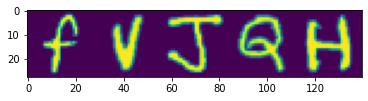

In [143]:
import matplotlib.pyplot as plt

dataset_sequences[0].shape

plt.imshow(dataset_sequences[0])

print(dataset_labels[0])

In [144]:
batch_size = 200

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = torch.utils.data.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [ ]:
class CRNNBase(nn.Module):
  def __init__(self,input_shape,gru_hidden_size,gru_num_layers,nun_classes):
    super(CRNNBase, self).__init__()
    self.input_shape = input_shape
    self.gru_hidden_size = gru_hidden_size
    self.gru_num_layers = gru_num_layers
    self.nun_classes = nun_classes
    self.fc = nn.Linear(gru_hidden_size * 2, num_classes)
    self.log_softmax = nn.LogSoftmax(dim=-1)
  
  def calculate_output_sizes(self):
    self.cnn_out_shape = self.conv_layer(torch.zeros(self.input_shape)).shape
    self.gru_input_size = self.cnn_out_shape[1]*self.cnn_out_shape[2]
  

  def forward(self,x):
    batch_size = x.shape[0]
    out = self.conv_layer(x)
    out = out.reshape(batch_size, -1, self.gru_input_size)
    out,_= self.rnn_layer(out)
    out = self.dense_layer(out)
    out = torch.stack([self.log_softmax(out[i]) for i in range(out.shape[0])])
    target_lengths = input_lengths = torch.IntTensor(batch_size).fill_(out.shape[1])
    return out,target_lengths



In [145]:
class CRNN3(CRNNBase):
  def __init__(self,input_shape,gru_hidden_size=256,gru_num_layers=3,nun_classes=27):
    super(CRNN3, self).__init__(input_shape,gru_hidden_size,gru_num_layers,nun_classes=nun_classes)
    # self.leaky_relu = nn.LeakyReLU()
    self.leaky_relu = nn.LeakyReLU() # try to solve exploding gradient problem
    self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7))
    self.norm1 = nn.InstanceNorm2d(64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3),stride=2)
    self.norm2 = nn.InstanceNorm2d(128)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=(3, 3))
    self.norm3 = nn.InstanceNorm2d(128)
    self.conv32 = nn.Conv2d(128, 128, kernel_size=(3, 3))
    self.norm32 = nn.InstanceNorm2d(128)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3),stride=2)
    self.norm4 = nn.InstanceNorm2d(256)
    self.dropout = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.1)
    self.num_classes = num_classes
    # torch.nn.init.constant_(self.conv1.weight,0.0)
    # torch.nn.init.constant_(self.conv2.weight,0.0)
    # torch.nn.init.constant_(self.conv3.weight,0.0)
    # torch.nn.init.constant_(self.conv4.weight,0.0)
    self.calculate_output_sizes()
    self.gru = nn.GRU(self.gru_input_size, self.gru_hidden_size, self.gru_num_layers, 
                      batch_first=True, bidirectional=True,dropout=0.3)
    # torch.nn.init.constant_(self.gru.weight_hh_l0,0.01)
    # torch.nn.init.constant_(self.gru.weight_hh_l1,0.01)
    # torch.nn.init.constant_(self.gru.weight_hh_l2,0.01)
    # torch.nn.init.constant_(self.gru.weight_hh_l0_reverse,0.01)
    # torch.nn.init.constant_(self.gru.weight_hh_l1_reverse,0.01)
    # torch.nn.init.constant_(self.gru.weight_hh_l2_reverse,0.01)

    self.fc = nn.Linear(self.gru_hidden_size * 2, 27)
    
  def rnn_layer(self,x):
    x = self.gru(x)
    return x
  
  def dense_layer(self,x):
    x = self.fc(x)
    return x

  def conv_layer(self,x):
    out = self.conv1(x)
    out = self.norm1(out)
    out = self.leaky_relu(out)
    out = self.dropout(out)
    out = self.conv2(out)
    out = self.norm2(out)
    out = self.leaky_relu(out)
    out = self.dropout(out)
    out = self.conv3(out)
    out = self.norm3(out)
    out = self.leaky_relu(out)
    out = self.dropout2(out)
    out = self.conv32(out)
    out = self.norm32(out)
    out = self.leaky_relu(out)
    out = self.dropout2(out)
    out = self.conv4(out)
    out = self.norm4(out)
    out = self.leaky_relu(out)
    out = self.dropout2(out)
    return out

model = CRNN3([1,1,28,140])

features,labels = next(iter(train_loader))

out = model(features.unsqueeze(1))

print(out[0].shape)
print(labels.shape)


torch.Size([64, 30, 27])
torch.Size([64, 5])


In [147]:
model = CRNN3([1,1,28,140])
gpu = torch.device('cuda:0')
model.to(gpu)
criterion = nn.CTCLoss(blank=0, reduction='mean',zero_infinity=True)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss = None
for epoch in range(10):
  for i,(features,labels) in enumerate(train_loader):
    optimizer.zero_grad()
    features = features.unsqueeze(1).to(gpu)
    out,input_lengths = model(features)
    out = out.permute(1,0,2)
    # target = vectorize_text(labels)
    target = labels.to(gpu)
    
    # input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
    target_lengths = torch.IntTensor([len(t) for t in labels])
    loss = criterion(out, target, input_lengths, target_lengths)
    # print(loss,epoch)
    loss.backward()
    if torch.isnan(loss):
      break
    optimizer.step()
    # print(loss,epoch)
  print(loss)

tensor(3.5432, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(2.6898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.8615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5630, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.8777, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.7290, device='cuda:0', grad_fn=<MeanBackward0>)


[26  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 26  8 10]
[26, 8, 26, 8, 10]
tensor([26,  8, 26,  8, 10], dtype=torch.int32)
zhzhj


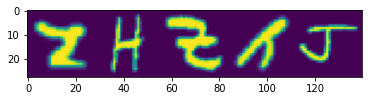

In [158]:
it = iter(train_loader)
features, labels = next(it)
features, labels = next(it)

import itertools 

def predict(out):
  iter = itertools.groupby(torch.argmax(out,dim=2).cpu().numpy()[0])
  x = []
  for i in iter:
    j = i[0]
    if j!= 0:
      x.append(j)
  return x

def evaluate(val_loader):
  correct = 0
  all = 0
  for features, labels in val_loader:
    out = model(features.unsqueeze(0).to(gpu))
    y_pred = torch.tensor(predict(out[0].cpu()),dtype=torch.int32)
    y_true = labels[0]
    if y_pred.shape[0] == y_true.shape[0]:
      x = y_true == y_true
      if x.all():
        correct+=1
    all+=1
  return correct/all

def pred2str(pred):
  s = ''
  alpha = 'abcdefghijklmnopqrstuvwxyz'
  for p in pred: 
    s+=(alpha[p-1])
  return s

features.shape
out = model(features.unsqueeze(1).to(gpu))
print(torch.argmax(out[0],dim=2).cpu().numpy()[0])
y_pred = predict(out[0].cpu())
y_true = labels[0]
print(y_pred)
# print(pred2str(y_pred))
print(y_true)
print(pred2str(y_pred))
_=plt.imshow(features[0])

# p = (predict(out[0].cpu()) == torch.tensor(labels)[0])

In [ ]:
out[0].shape

torch.Size([64, 27])

In [159]:
evaluate(val_loader)

0.8675

In [160]:
torch.save(model.cpu(),'hw_recog_v1.pth')